In [1]:
from __future__ import division, print_function
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
from IPython.display import display, Math, Latex
from math import log, sqrt
import editdistance


In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [102]:

# Experiment selection : 
exp="exp3"

filepairsab = "../Datas/"+exp+"/pairs_ab.tsv"
filepairsaa = "../Datas/"+exp+"/pairs_aa.tsv"
filepairsbb = "../Datas/"+exp+"/pairs_bb.tsv"
filea = "../Datas/"+exp+"/sequences_alpha.tsv"
fileb = "../Datas/"+exp+"/sequences_beta.tsv"

def H(prob):
    return -sum(prob.apply(lambda x: x*log(x,2)))

def mutual_information(df, keys):
    """ Return a numerical array containing the mutual 
        informations between the different keys.
    """
    p = {k: (df[k].value_counts())/len(df) for k in keys}
    p2 = {(k,l):(df.groupby([k, l]).size())/len(df) for k in keys for l in keys}
    I = {(k,l): -H(p2[k,l]) + H(p[k]) + H(p[l]) for k in keys for l in keys}

    # Correct the mutual information bias for small sizes
    corr_I = {(k,l): 
              (len(df[k].value_counts())*len(df[l].value_counts()) -
                     len(df[k].value_counts()) -len(df[l].value_counts()) +
                     1)/(2*df.size*log(2))
              for k in keys for l in keys}
    nI = {(k,l): (- H(p2[k,l]) + H(p[k]) + H(p[l]) - corr_I[k,l]) for k in keys for l in keys}
    Is = np.zeros((len(keys), len(keys)))
    for k in range(len(keys)):
        for l in range(len(keys)):
            Is[k, l] = (nI[keys[k], keys[l]] if l!=k else 0)
            #print(keys[k], keys[l], Is[k,l])
    return Is

def mutual_information_dict(df, keys):
    p = {k: (df[k].value_counts())/len(df) for k in keys}
    p2 = {(k,l):(df.groupby([k, l]).size())/len(df) for k in keys for l in keys}
    I = {(k,l): -H(p2[k,l]) + H(p[k]) + H(p[l]) for k in keys for l in keys}
    return I
    

# Mutual information

This notebook compute the mutual information between two paired TCR sequences $(\alpha, \beta)$, $(\alpha, \alpha)$ and $(\beta, \beta)$. 

                                  $V_\alpha$  $J_\alpha$  \
$V_\alpha$                          0.000000    0.169015   
$J_\alpha$                          0.169015    0.000000   
$\mathrm{del}\ V_\alpha$            0.170234    0.022817   
$\mathrm{del}\ J_\alpha$            0.020882    0.463466   
$\mathrm{ins}_\alpha$               0.025872    0.163369   
$V_\beta$                           0.036416    0.033196   
$D_\beta$                           0.000529    0.000544   
$J_\beta$                           0.010347    0.007887   
$\mathrm{del}\ V_\beta$             0.009376    0.009555   
$\mathrm{del}\ 5^\prime D_\beta$    0.005653    0.006353   
$\mathrm{del}\ 3^\prime D_\beta$    0.004978    0.005571   
$\mathrm{del}\ J_\beta$             0.009891    0.010005   
$\mathrm{ins\ VD}_\beta$            0.009958    0.010748   
$\mathrm{ins\ DJ}_\beta$            0.009582    0.010684   

                                  $\mathrm{del}\ V_\alpha$  \
$V_\alpha$                           

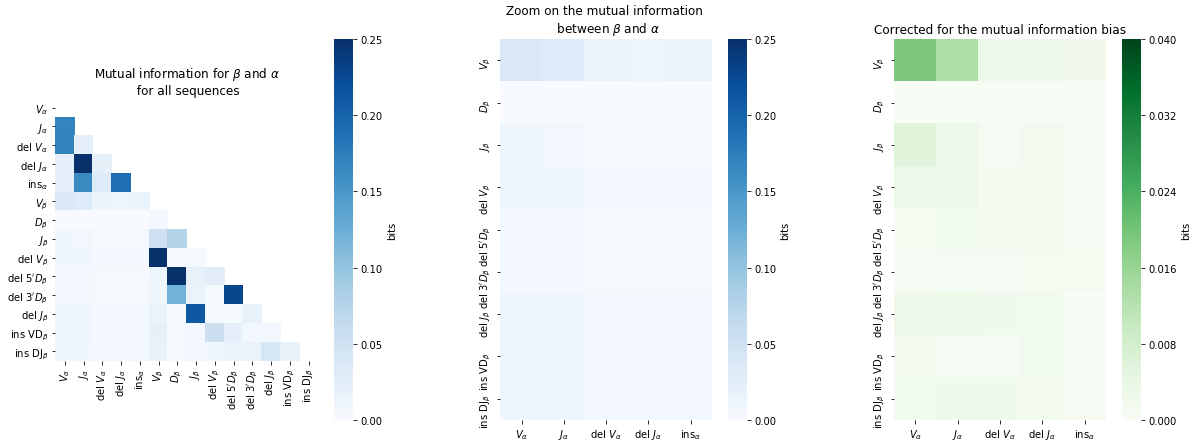

In [6]:
df = pd.read_csv(filepairsab, sep='\t')

keys = ['vname_1', 'jname_1', 'vdel_1', 'jdel_1', 'n1ins_1', 'vname_2', 'dname_2',
        'jname_2', 'vdel_2', 'd5del_2', 'd3del_2', 'jdel_2', 'n2ins_2', 'n1ins_2']
dfshuffled = df[keys].copy()
df = df[keys].copy()

df_alpha = df[['vname_1', 'jname_1', 'vdel_1', 'jdel_1', 'n1ins_1']].copy()
df_beta = df[['vname_2', 'dname_2','jname_2', 'vdel_2',
              'd5del_2', 'd3del_2', 'jdel_2', 'n2ins_2', 'n1ins_2']].copy()
df_beta = df_beta.sample(frac=1).reset_index(drop=True)
df_shuffled = pd.concat([df_alpha, df_beta], axis=1)


df = df.dropna()
df_shuffled = df_shuffled.dropna()

Is = mutual_information(df, keys)
Is_shuffled = mutual_information(df_shuffled, keys)


indx = [r'$V_\alpha$', r'$J_\alpha$', r'$\mathrm{del}\ V_\alpha$', r'$\mathrm{del}\ J_\alpha$',
        r'$\mathrm{ins}_\alpha$', r'$V_\beta$',r'$D_\beta$', r'$J_\beta$', r'$\mathrm{del}\ V_\beta$',
        r'$\mathrm{del}\ 5^\prime D_\beta$', r'$\mathrm{del}\ 3^\prime D_\beta$', r'$\mathrm{del}\ J_\beta$',
        r'$\mathrm{ins\ VD}_\beta$', r'$\mathrm{ins\ DJ}_\beta$']

u_corrected = pd.DataFrame(Is - Is_shuffled, index=indx, columns=indx)
u_corrected_zoom = pd.DataFrame(Is[5:, :5] - Is_shuffled[5:, :5], index=indx[5:], columns=indx[:5])
u = pd.DataFrame(Is, index=indx, columns=indx)
u_zoom = pd.DataFrame(Is[5:, :5], index=indx[5:], columns=indx[:5])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

mask=np.zeros_like(u)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(u, vmin=0., vmax=0.25, mask=mask, cmap="Blues", square=True, ax=ax1, cbar_kws={'label': 'bits'})
ax1.set_title("Mutual information for $\\beta$ and $\\alpha$ \n for all sequences")
sns.heatmap(u_zoom, vmin=0., vmax=0.25, cmap="Blues", square=True, ax=ax2, cbar_kws={'label': 'bits'})
ax2.set_title("Zoom on the mutual information \n between $\\beta$ and $\\alpha$")
sns.heatmap(u_corrected_zoom, vmin=0., vmax=0.04, cmap="Greens", square=True, ax=ax3, cbar_kws={'label': 'bits'})
ax3.set_title("Corrected for the mutual information bias")

print(u)

print("$V_\alpha, V_\beta", u[r'$V_\alpha$'])
print("$V_\alpha, J_\beta", u[r'$V_\beta$'])

plt.savefig("mutual_information_ab.pdf")

plt.show()

## Mutual information between pairs $(\alpha-\alpha)$ and $(\beta-\beta)$

The distance distribution permits to discriminate between real and fake pairings.

/home/tautilde/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


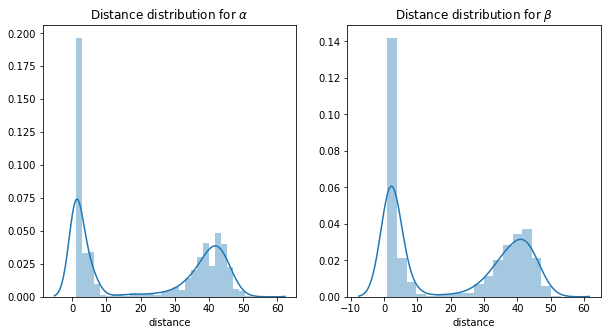

In [11]:
dfb = pd.read_csv(fileb, sep="\t")
dfbb = pd.read_csv(filepairsbb, sep='\t')
dfaa = pd.read_csv(filepairsaa, sep='\t')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
sns.distplot(dfaa.distance, ax=ax1)
ax1.set_title(r"Distance distribution for $\alpha$")
sns.distplot(dfbb.distance, ax=ax2)
ax2.set_title(r"Distance distribution for $\beta$")


dfbb = dfbb[dfbb.distance > 20]
dfaa = dfaa[dfaa.distance > 20]


plt.show()

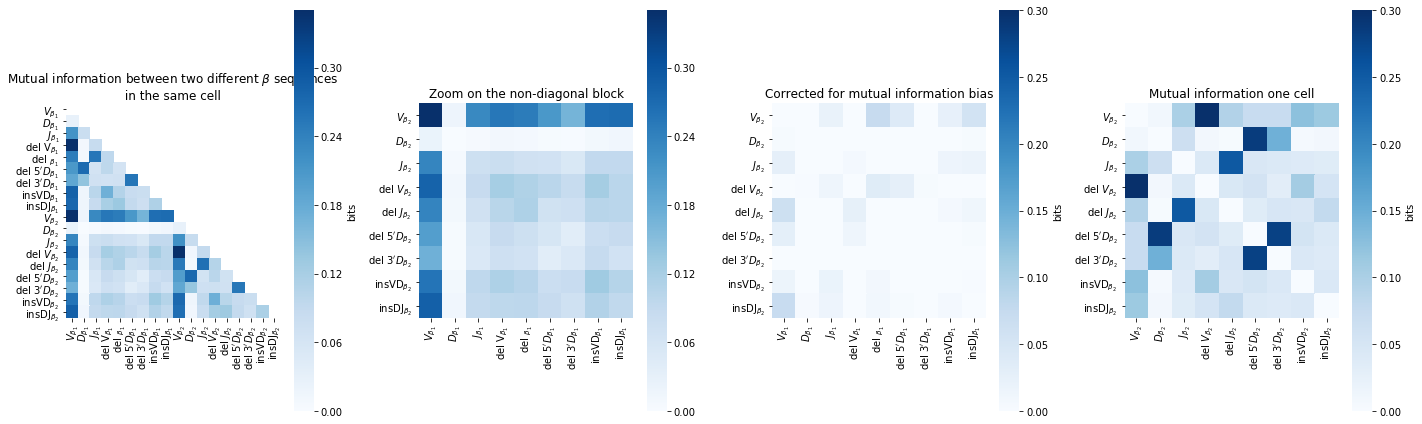

In [12]:
base_keys =  ['vname', 'dname', 'jname', 'vdel',
         'jdel','d5del','d3del', 'n2ins', 'n1ins']
keys = [u + "_1" for u in base_keys] + [u + "_2" for u in base_keys]

# drop sequences for which VDJ couldn't be inferred
dfbb = dfbb.dropna()

# not a lot of paired sequences for beta so it is better to 
# correct with random sequences rather than using the shuffled ones
dfb = dfb.dropna()
df_beta_1 = dfb[['vname', 'dname','jname', 'vdel',
              'd5del', 'd3del', 'jdel','n2ins', 'n1ins']].copy().reset_index(drop=True)
df_beta_2 = df_beta_1.copy().reset_index(drop=True) #shuffle
df_beta_1.columns = [u + "_1" for u in base_keys]
df_beta_2.columns = [u + "_2" for u in base_keys]
df_shuffled = pd.concat([df_beta_1, df_beta_2], axis=1)
df_shuffled = df_shuffled.sample(len(dfbb))
Is = mutual_information(dfbb, keys)
Is_shuffled = mutual_information(df_shuffled, keys)

Is_onebeta = mutual_information(dfb, base_keys)
    
indx = [r'$V_{\beta_1}$',r'$D_{\beta_1}$', r'$J_{\beta_1}$', r'$\mathrm{del\ V}_{\beta_1}$', r'$\mathrm{del\ }_{\beta_1}$', 
         r'$\mathrm{del\ }5^\prime D_{\beta_1}$', r'$\mathrm{del\ }3^\prime D_{\beta_1}$', r'$\mathrm{ins VD}_{\beta_1}$',
        r'$\mathrm{ins DJ}_{\beta_1}$', r'$V_{\beta_2}$',r'$D_{\beta_2}$', r'$J_{\beta_2}$', r'$\mathrm{del}\ V_{\beta_2}$',
         r'$\mathrm{del}\ J_{\beta_2}$', r'$\mathrm{del}\ 5^\prime D_{\beta_2}$', r'$\mathrm{del}\ 3^\prime D_{\beta_2}$', 
         r'$\mathrm{ins VD}_{\beta_2}$', r'$\mathrm{ins DJ}_{\beta_2}$']

u = pd.DataFrame(Is, index=indx, columns=indx)
u_corrected_zoom = pd.DataFrame(Is[9:, :9]- Is_shuffled[9:, :9], index=indx[9:], columns=indx[:9])
u_zoom = pd.DataFrame(Is[9:,:9], index=indx[9:], columns=indx[:9])
u_onebeta = pd.DataFrame(Is_onebeta, index=indx[9:], columns=indx[9:])

mask=np.zeros_like(u)
mask[np.triu_indices_from(mask, 0)] = True

fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(20, 6))
sns.heatmap(u, vmin=0., vmax=0.35, mask=mask, ax=ax1, cmap="Blues", square=True, cbar_kws={'label': 'bits'})
ax1.set_title("Mutual information between two different $\\beta$ sequences \n in the same cell ")
sns.heatmap(u_zoom, vmin=0., vmax=0.35, ax=ax2, cmap="Blues", square=True)
ax2.set_title(r"Zoom on the non-diagonal block")
sns.heatmap(u_corrected_zoom, vmin=0., vmax=0.30, ax=ax3, cmap="Blues", square=True, cbar_kws={'label': 'bits'})
ax3.set_title(r"Corrected for mutual information bias")

sns.heatmap(u_onebeta, vmin=0., vmax=0.30, ax=ax4, cmap="Blues", square=True, cbar_kws={'label': 'bits'})
ax4.set_title(r"Mutual information one cell")
plt.tight_layout()
plt.savefig("mutual_information_bb.pdf")


plt.show()

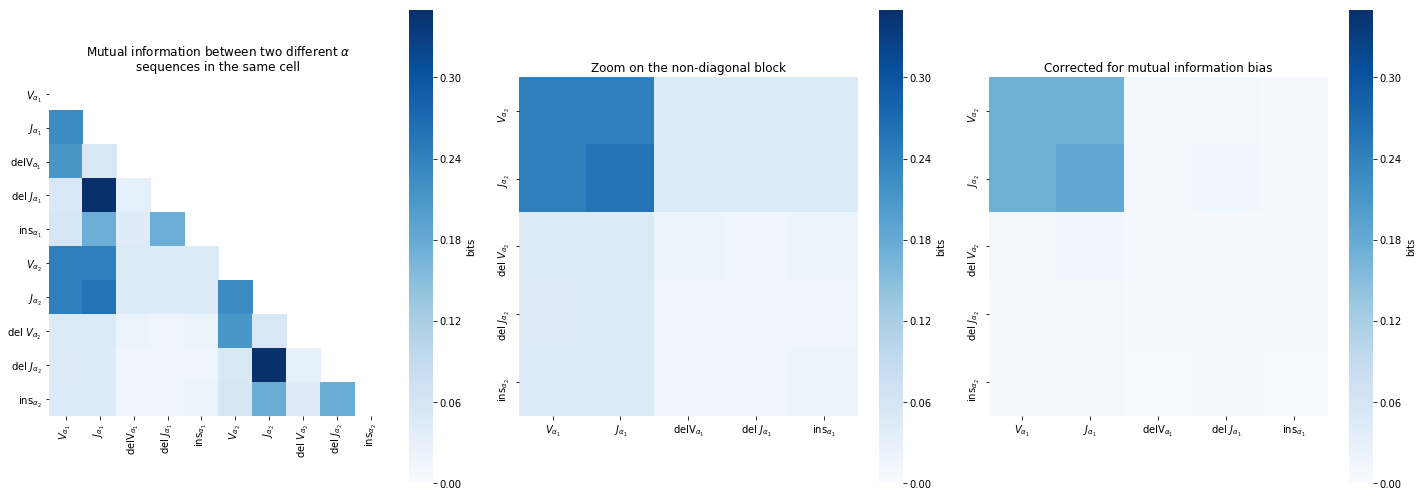

In [13]:
keys = ['vname', 'jname', 'vdel', 'jdel', 'n1ins']
keys_1 = [u+"_1" for u in keys]
keys_2 = [u+"_2" for u in keys]
keys = keys_1 + keys_2

dfaa.reset_index(drop=True)

df_alpha_1 = dfaa[keys_1].copy().reset_index(drop=True)
df_alpha_2 = dfaa[keys_2].copy().reset_index(drop=True)

df_alpha_2 = df_alpha_2.sample(frac=1).reset_index(drop=True) #shuffle
df_shuffled = pd.concat([df_alpha_1, df_alpha_2], axis=1)


Is = mutual_information(dfaa, keys)
Is_shuffled = mutual_information(df_shuffled, keys)

indx = [r'$V_{\alpha_1}$', r'$J_{\alpha_1}$', r'$\mathrm{del V}_{\alpha_1}$',
         r'$\mathrm{del}\ J_{\alpha_1}$', r'$\mathrm{ins}_{\alpha_1}$',
       r'$V_{\alpha_2}$',
        r'$J_{\alpha_2}$', r'$\mathrm{del}\ V_{\alpha_2}$', r'$\mathrm{del}\ J_{\alpha_2}$', r'$\mathrm{ins}_{\alpha_2}$']
u = pd.DataFrame(Is, index=indx, columns=indx)
u_corrected_zoom = pd.DataFrame(Is[5:, :5]  - Is_shuffled[5:, :5], index=indx[5:], columns=indx[:5])
u_zoom = pd.DataFrame(Is[5:, :5], index=indx[5:], columns=indx[:5])


mask=np.zeros_like(u)
mask[np.triu_indices_from(mask, 0)] = True

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
sns.heatmap(u, vmin=0., vmax=0.35, mask=mask, ax=ax1, cmap="Blues", square=True,cbar_kws={'label': 'bits'})
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax1.set_title("Mutual information between two different $\\alpha$ \n sequences in the same cell ")
sns.heatmap(u_zoom, vmin=0., vmax=0.35, ax=ax2, cmap="Blues", square=True, cbar_kws={'label': 'bits'})
ax2.set_title(r"Zoom on the non-diagonal block")
sns.heatmap(u_corrected_zoom, vmin=0., vmax=0.35, ax=ax3, cmap="Blues", square=True, cbar_kws={'label': 'bits'})
ax3.set_title(r"Corrected for mutual information bias")

plt.tight_layout()
plt.savefig("mutual_information_aa.pdf")

plt.show()

## Selection model 

The aim of this section is to infer a "minimal selection model", that would only add interactions between the two Vs of the alpha and beta chains. This selection factor is simply inferred from the data by using:
$$
q_{V_A, V_B} = \frac{P_{exp}(V_A, V_B)}{P_{gen}(V_A) P_{gen}(V_B)} 
$$

From this experimental selection factor, we can create a probability model with an adjustable selection level:

$$
P^{T}(V_A, V_B) \propto \left(q_{V_A, V_B}\right)^{T^{-1}} P_{gen}(V_A) P_{gen}(V_B)
$$
Where $T$ is a temperature. There is no selection at $T = \infty$, and $T = 0$ means that only the most common pairs of sequences $(V_A, V_B)$ are selected (maximal selection).

Note that this transformation does not conserve the marginal distribution $p(V_A)$ and $p(V_B)$.
This creates a selection model with a tunable parameter. We can then generate sequences using IGoR and pair them according to the selection factor $q^{T^{-1}}$.

In [35]:
## Load generated sequences
dfa = pd.read_csv("../Datas/generated_sequences/tra_generated/generated_realizations_noerr.csv", sep=";")
mapva = {}
with open("../Datas/generated_sequences/tra_generated/vmap.csv", "r") as f:
    for l in f:
        mapva["(" + l.split(";")[1].strip() + ")"] = l.split(";")[0]
mapja = {}
with open("../Datas/generated_sequences/tra_generated/jmap.csv", "r") as f:
    for l in f:
        mapja["(" + l.split(";")[1].strip() + ")"] = l.split(";")[0]

dfa["V"] = (dfa.GeneChoice_V_gene_Undefined_side_prio7_size103.map(mapva))
dfa["J"] = (dfa.GeneChoice_J_gene_Undefined_side_prio6_size68.map(mapja))

dfb = pd.read_csv("../Datas/generated_sequences/trb_generated/generated_realizations_noerr.csv", sep=";")
mapvb = {}
with open("../Datas/generated_sequences/trb_generated/vmap.csv", "r") as f:
    for l in f:
        mapvb["(" + l.split(";")[1].strip() + ")"] = l.split(";")[0]
mapjb = {}
with open("../Datas/generated_sequences/trb_generated/jmap.csv", "r") as f:
    for l in f:
        mapjb["(" + l.split(";")[1].strip() + ")"] = l.split(";")[0]

dfb["V"] = (dfa.GeneChoice_V_gene_Undefined_side_prio7_size103.map(mapvb))
dfb["J"] = (dfa.GeneChoice_J_gene_Undefined_side_prio6_size68.map(mapjb))

df_pairs_a = pd.read_csv("../Datas/generated_sequences/pairs/tcra_pairs_output/best_scenarios_counts.csv", sep=";")
df_pairs_b = pd.read_csv("../Datas/generated_sequences/pairs/tcrb_pairs_output/best_scenarios_counts.csv", sep=";")

df_pairs = pd.merge(df_pairs_a, df_pairs_b, on='seq_index', suffixes=["_alpha", "_beta"])
df_pairs["V_alpha"] = df_pairs.GeneChoice_V_gene_Undefined_side_prio7_size103.map(mapva)
df_pairs["V_beta"] = df_pairs.GeneChoice_V_gene_Undefined_side_prio7_size89.map(mapvb)
df_pairs["J_alpha"] = df_pairs.GeneChoice_J_gene_Undefined_side_prio6_size68.map(mapja)
df_pairs["J_beta"] = df_pairs.GeneChoice_J_gene_Undefined_side_prio7_size15.map(mapjb)


In [36]:
mutual_information(df_pairs, keys=["V_alpha", "V_beta", "J_alpha", "J_beta"])

array([[0.        , 0.02985691, 0.24213357, 0.00831352],
       [0.02985691, 0.        , 0.02814179, 0.07334609],
       [0.24213357, 0.02814179, 0.        , 0.0068834 ],
       [0.00831352, 0.07334609, 0.0068834 , 0.        ]])

In [37]:
# compute selection factor q
ordered_V_A = sorted(dfa.V.value_counts()[dfa.V.value_counts() > 10000].index)
ordered_V_B = sorted(dfb.V.value_counts()[dfb.V.value_counts() > 10000].index)
inv_V_A = {ordered_V_A[k]:k for k in range(len(ordered_V_A))}
inv_V_B = {ordered_V_B[k]:k for k in range(len(ordered_V_B))}

dfa = dfa[dfa.V.isin(ordered_V_A)].copy()
dfa["seq_index"] = np.random.permutation(dfa.seq_index) # random shuffle

dfb = dfb[dfb.V.isin(ordered_V_B)].copy()
dfb["seq_index"] = np.random.permutation(dfb.seq_index) # random shuffle

df_pairs = df_pairs[(df_pairs.V_alpha.isin(ordered_V_A)) &
                   (df_pairs.V_beta.isin(ordered_V_B))]
df_pairs["Va_Vb"] = df_pairs.apply(lambda r: (r['V_alpha'], r['V_beta']), axis=1)
va_vb_vc = df_pairs.Va_Vb.value_counts().to_dict()

pAB = np.array([[(lambda x: va_vb_vc[x] if x in va_vb_vc else 0.)
                 ((ordered_V_A[k1], ordered_V_B[k2]))
               for k2 in range(len(ordered_V_B))]
               for k1 in range(len(ordered_V_A))])
pAB = pAB/np.sum(pAB)

pgenA = np.array([np.mean(dfa['V'] == ordered_V_A[k1])
                                     for k1 in range(len(ordered_V_A))])
pgenA = pgenA/np.sum(pgenA)

pgenB = np.array([np.mean(dfb['V'] == ordered_V_B[k2])
                                     for k2 in range(len(ordered_V_B))])
pgenB = pgenB/np.sum(pgenB)

pgenAB = np.tensordot(pgenA, pgenB, 0)
qAB = pAB/pgenAB

In [112]:

# dfgen_a = dfa[["V", "J"]].dropna().sample(N, replace=True)
# dfgen_b = dfa[["V", "J"]].dropna().sample(N, replace=True)
# dfgen_a["i"] = range(N)
# dfgen_b["i"] = range(N)

# df_pairs_gen = pd.merge(dfa[["V", "J"]].dropna(),
#                         dfb[["V", "J"]].dropna(), suffixes=["_alpha", "_beta"])
# print(df_pairs_gen)

def pairs_gen(T=1., size=1, dfa=dfa, dfb=dfb):

    df_pairs_gen = pd.DataFrame()
    dfa = dfa.dropna(subset=["V", "J"])
    dfb = dfb.dropna(subset=["V", "J"])

    dfa["nb_V"] = dfa.V.map(inv_V_A)
    dfb["nb_V"] = dfb.V.map(inv_V_B)
    nb=0

    M=100000
    while len(df_pairs_gen) < size:
        dfgen_a = dfa.sample(M, replace=True).copy()
        dfgen_a["i"] = range(len(dfgen_a))
        dfgen_b = dfb.sample(M, replace=True).copy()
        dfgen_b["i"] = np.random.permutation(range(len(dfgen_a)))
        df_pairs_tmp = pd.merge(dfgen_a[["V", "J", "i", "nb_V"]],
                                dfgen_b[["V", "J", "i", "nb_V"]],
                                on="i", suffixes=["_alpha", "_beta"], sort=True)
        df_pairs_tmp["qAB"] = df_pairs_tmp.apply(
            lambda r: qAB[r["nb_V_alpha"], r["nb_V_beta"]]**(1./T), axis=1)
        df_pairs_tmp["keep"] = ((np.random.random(size=df_pairs_tmp.shape[0])*np.max(qAB)) 
                            < df_pairs_tmp.qAB)
        df_pairs_gen = df_pairs_gen.append(df_pairs_tmp[df_pairs_tmp.keep].copy(), ignore_index=True)
    print(len(df_pairs_gen))
    return df_pairs_gen.sample(n=size)


df_pairs_gen = pairs_gen(size=400000, dfa=dfa, dfb=dfb)

# df_pairs_gen["nb_V_A"] = df_pairs_gen.V_alpha.map(inv_V_A).apply(int)
# df_pairs_gen["nb_V_B"] = df_pairs_gen.V_beta.map(inv_V_B).apply(int)
# df_pairs_gen["qAB"] = df_pairs_gen.apply(lambda r: qAB[r["nb_V_A"], r["nb_V_B"]], axis=1)

# df_pairs_gen["keep"] = (np.random.random(size=df_pairs_gen.shape[0])*np.max(qAB)) < df_pairs_gen.qAB

# df_pairs_gen = df_pairs_gen[df_pairs_gen.keep].copy()

df_pairs_gen["Va_Vb"] = df_pairs_gen.apply(lambda r: (r['V_alpha'], r['V_beta']), axis=1)
va_vb_vc = df_pairs_gen.Va_Vb.value_counts().to_dict()
pgenAB_corr = np.array([[(lambda x: va_vb_vc[x] if x in va_vb_vc else 0.)
                 ((ordered_V_A[k1], ordered_V_B[k2]))
               for k2 in range(len(ordered_V_B))]
               for k1 in range(len(ordered_V_A))])
pgenAB_corr = pgenAB_corr/np.sum(pgenAB_corr)

401206


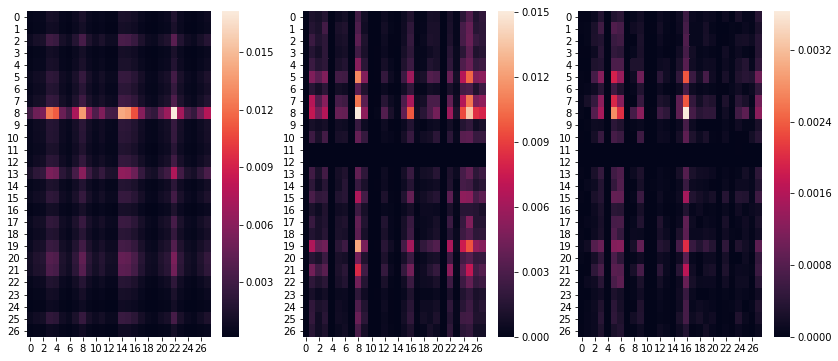

In [111]:
fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize=(14,6))
sns.heatmap(pgenAB, ax=ax1)
sns.heatmap(pAB, ax=ax2)
sns.heatmap(np.abs(pgenAB_corr - pAB), ax=ax3)
plt.show()

In [ ]:
mutinfVaVb = []
mutinfVaJb = []
for logT in np.arange(-1, 2, 0.2):
    dct = mutual_information_dict(pairs_gen(T=10**logT, size=400000, dfa=dfa, dfb=dfb)
                                 , keys=["V_alpha", "V_beta", "J_alpha", "J_beta"])
    mutinfVaVb.append(dct[('V_alpha', 'V_beta')])
    mutinfVaJb.append(dct[('V_alpha', 'J_beta')])

408276


In [104]:
mutual_information_dict(df_pairs[["V_alpha", "V_beta", "J_alpha", "J_beta"]].dropna(), keys=["V_alpha", "V_beta", "J_alpha", "J_beta"])

{('V_alpha', 'V_alpha'): 4.381155343322471,
 ('V_alpha', 'V_beta'): 0.023251026070418845,
 ('V_alpha', 'J_alpha'): 0.19673146367590189,
 ('V_alpha', 'J_beta'): 0.010174089974271272,
 ('V_beta', 'V_alpha'): 0.023251026070413516,
 ('V_beta', 'V_beta'): 4.092429278587166,
 ('V_beta', 'J_alpha'): 0.03378562913192251,
 ('V_beta', 'J_beta'): 0.08389202092313264,
 ('J_alpha', 'V_alpha'): 0.1967314636759001,
 ('J_alpha', 'V_beta'): 0.03378562913191363,
 ('J_alpha', 'J_alpha'): 5.538537982155904,
 ('J_alpha', 'J_beta'): 0.015778213480732273,
 ('J_beta', 'V_alpha'): 0.010174089974275269,
 ('J_beta', 'V_beta'): 0.08389202092313486,
 ('J_beta', 'J_alpha'): 0.01577821348072561,
 ('J_beta', 'J_beta'): 3.4705097440594286}

In [99]:
len(df_pairs_gen[["V_alpha", "V_beta", "J_alpha", "J_beta"]].dropna())

341606

## Raw vs Null mutual information

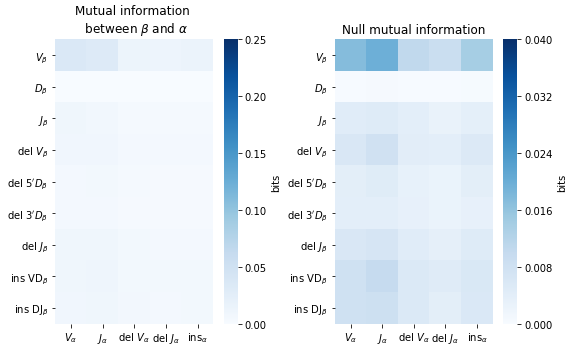

In [34]:
df = pd.read_csv(filepairsab, sep='\t')

keys = ['vname_1', 'jname_1', 'vdel_1', 'jdel_1', 'n1ins_1', 'vname_2', 'dname_2',
        'jname_2', 'vdel_2', 'd5del_2', 'd3del_2', 'jdel_2', 'n2ins_2', 'n1ins_2']
dfshuffled = df[keys].copy()
df = df[keys].copy()

df_alpha = df[['vname_1', 'jname_1', 'vdel_1', 'jdel_1', 'n1ins_1']].copy()
df_beta = df[['vname_2', 'dname_2','jname_2', 'vdel_2',
              'd5del_2', 'd3del_2', 'jdel_2', 'n2ins_2', 'n1ins_2']].copy()
df_beta = df_beta.sample(frac=1).reset_index(drop=True)
df_shuffled = pd.concat([df_alpha, df_beta], axis=1)


df = df.dropna()
df_shuffled = df_shuffled.dropna()

Is = mutual_information(df, keys)
Is_shuffled = mutual_information(df_shuffled, keys)


indx = [r'$V_\alpha$', r'$J_\alpha$', r'$\mathrm{del}\ V_\alpha$', r'$\mathrm{del}\ J_\alpha$',
        r'$\mathrm{ins}_\alpha$', r'$V_\beta$',r'$D_\beta$', r'$J_\beta$', r'$\mathrm{del}\ V_\beta$',
        r'$\mathrm{del}\ 5^\prime D_\beta$', r'$\mathrm{del}\ 3^\prime D_\beta$', r'$\mathrm{del}\ J_\beta$',
        r'$\mathrm{ins\ VD}_\beta$', r'$\mathrm{ins\ DJ}_\beta$']

u_null = pd.DataFrame(Is_shuffled, index=indx, columns=indx)
u_null_zoom = pd.DataFrame(Is_shuffled[5:, :5], index=indx[5:], columns=indx[:5])
u = pd.DataFrame(Is, index=indx, columns=indx)
u_zoom = pd.DataFrame(Is[5:, :5], index=indx[5:], columns=indx[:5])

fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(8, 5))

mask=np.zeros_like(u)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(u_zoom, vmin=0., vmax=0.25, cmap="Blues", square=True, ax=ax2, cbar_kws={'label': 'bits'})
ax2.set_title("Mutual information \n between $\\beta$ and $\\alpha$")
sns.heatmap(u_null_zoom, vmin=0., vmax=0.04, cmap="Blues", square=True, ax=ax3, cbar_kws={'label': 'bits'})
ax3.set_title("Null mutual information")

plt.tight_layout()
plt.savefig("mutual_information_ab_true_vs_null.pdf")

plt.show()

/home/tautilde/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


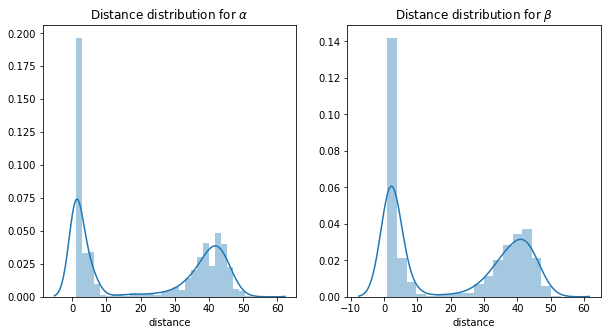

In [8]:
dfb = pd.read_csv(fileb, sep="\t")
dfbb = pd.read_csv(filepairsbb, sep='\t')
dfaa = pd.read_csv(filepairsaa, sep='\t')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
sns.distplot(dfaa.distance, ax=ax1)
ax1.set_title(r"Distance distribution for $\alpha$")
sns.distplot(dfbb.distance, ax=ax2)
ax2.set_title(r"Distance distribution for $\beta$")


dfbb = dfbb[dfbb.distance > 20]
dfaa = dfaa[dfaa.distance > 20]

plt.show()

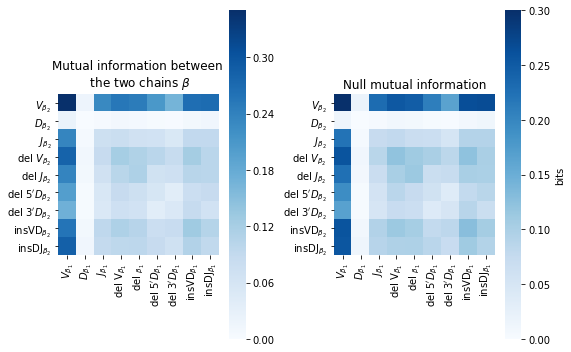

In [33]:
base_keys =  ['vname', 'dname', 'jname', 'vdel',
         'jdel','d5del','d3del', 'n2ins', 'n1ins']
keys = [u + "_1" for u in base_keys] + [u + "_2" for u in base_keys]

# drop sequences for which VDJ couldn't be inferred
dfbb = dfbb.dropna()

df_shuffled = dfbb.copy()
df_shuffled["vname_1"] = np.random.permutation(df_shuffled.vname_1)

Is = mutual_information(dfbb, keys)
Is_shuffled = mutual_information(df_shuffled, keys)


indx = [r'$V_{\beta_1}$',r'$D_{\beta_1}$', r'$J_{\beta_1}$', r'$\mathrm{del\ V}_{\beta_1}$', r'$\mathrm{del\ }_{\beta_1}$', 
         r'$\mathrm{del\ }5^\prime D_{\beta_1}$', r'$\mathrm{del\ }3^\prime D_{\beta_1}$', r'$\mathrm{ins VD}_{\beta_1}$',
        r'$\mathrm{ins DJ}_{\beta_1}$', r'$V_{\beta_2}$',r'$D_{\beta_2}$', r'$J_{\beta_2}$', r'$\mathrm{del}\ V_{\beta_2}$',
         r'$\mathrm{del}\ J_{\beta_2}$', r'$\mathrm{del}\ 5^\prime D_{\beta_2}$', r'$\mathrm{del}\ 3^\prime D_{\beta_2}$', 
         r'$\mathrm{ins VD}_{\beta_2}$', r'$\mathrm{ins DJ}_{\beta_2}$']

u = pd.DataFrame(Is, index=indx, columns=indx)
u_null_zoom = pd.DataFrame( Is_shuffled[9:, :9], index=indx[9:], columns=indx[:9])
u_zoom = pd.DataFrame(Is[9:,:9], index=indx[9:], columns=indx[:9])

mask=np.zeros_like(u)
mask[np.triu_indices_from(mask, 0)] = True

fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(8, 5))
sns.heatmap(u_zoom, vmin=0., vmax=0.35, ax=ax2, cmap="Blues", square=True)
ax2.set_title("Mutual information between \n the two chains $\\beta$")
sns.heatmap(u_null_zoom, vmin=0., vmax=0.30, ax=ax3, cmap="Blues", square=True, cbar_kws={'label': 'bits'})
ax3.set_title("Null mutual information")


plt.tight_layout()
plt.savefig("mutual_information_bb_true_vs_null.pdf")
plt.show()